### Imports

In [1]:
from src.digit_functions import loadDigits
from Models import ImageGradientDensityModel

import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"{torch.__version__}")
print(f"{np.__version__}")
print(f"{mpl.__version__}")
print(f"{device}")

2.0.0+cpu
1.24.2
3.7.1
cpu


# Image Gradient Density Based Sudoku Solver Model

### Load Generated Digits into DigitImageTrainTestDataset

In [2]:
SRC = "./data/digits/transformed/imageGradientDensity/"

transformedDigits = loadDigits(SRC)

(+) Reading data from .npy file...
(+) Digit loading finished


### Training

In [3]:
X_TRAIN_TENSOR = torch.tensor(transformedDigits[0][0], dtype=torch.float32)
Y_TRAIN_TENSOR = torch.tensor(transformedDigits[0][1] - 1, dtype=torch.long)
print(X_TRAIN_TENSOR.shape)
print(Y_TRAIN_TENSOR.shape)
X_TEST_TENSOR = torch.tensor(transformedDigits[1][0], dtype=torch.float32)
Y_TEST_TENSOR = torch.tensor(transformedDigits[1][1] - 1, dtype=torch.long)
print(X_TEST_TENSOR.shape)
print(Y_TEST_TENSOR.shape)

torch.Size([1496250, 8])
torch.Size([1496250])
torch.Size([78750, 8])
torch.Size([78750])


In [4]:
BATCH_SIZE = 256
tensorDataset = torch.utils.data.TensorDataset(X_TRAIN_TENSOR, Y_TRAIN_TENSOR)
dataloader = torch.utils.data.DataLoader(tensorDataset, BATCH_SIZE, shuffle=True)

In [5]:
model = ImageGradientDensityModel()
model = model.to(device)
lossfn = torch.nn.CrossEntropyLoss()

In [6]:
LEARNING_RATE = 0.001
BETAS = (0.9, 0.99)
EPS = 1e-5
optimizer = torch.optim.Adam(model.parameters(), LEARNING_RATE, BETAS, EPS)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.7, total_iters=225)

In [7]:
EPOCHS = 301

trainLosses = []
testLosses = []
trainAccuracies = []
testAccuracies = []

for epoch in range(EPOCHS):

    model.train()

    for x_batch, y_batch in dataloader:

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        _Y = model(x_batch)
        loss = lossfn(_Y, y_batch)

        loss.backward()

        optimizer.step()

    model.eval()

    _Y = model(X_TRAIN_TENSOR)
    trainLoss = lossfn(_Y, Y_TRAIN_TENSOR).item()
    trainLosses.append(trainLoss)
    trainAccuracy = accuracy_score(Y_TRAIN_TENSOR.detach().cpu().numpy(), _Y.detach().cpu().argmax(dim=1).numpy())
    trainAccuracies.append(trainAccuracy)

    _Y = model(X_TEST_TENSOR)
    testLoss = lossfn(_Y, Y_TEST_TENSOR).item()
    testLosses.append(testLoss)
    testAccuracy = accuracy_score(Y_TEST_TENSOR.detach().cpu().numpy(), _Y.detach().cpu().argmax(dim=1).numpy())
    testAccuracies.append(testAccuracy)

    scheduler.step()

    if epoch % 3 == 0:
        print(f"Epoch: {epoch}:")
        print(f"\tLosses: {trainLosses[-1]} - {testLosses[-1]}")
        print(f"\tAccuracies: {trainAccuracies[-1]} - {testAccuracies[-1]}")
        print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch: 0:
	Losses: 0.9581514000892639 - 0.9617965221405029
	Accuracies: 0.5648280701754386 - 0.5641015873015873
Current learning rate: 0.0009986666666666668
Epoch: 3:
	Losses: 0.5061593055725098 - 0.5061671137809753
	Accuracies: 0.7897383458646616 - 0.7893333333333333
Current learning rate: 0.0009946666666666665
Epoch: 6:
	Losses: 0.45033812522888184 - 0.4507676661014557
	Accuracies: 0.8121704260651629 - 0.8104126984126984
Current learning rate: 0.0009906666666666664
Epoch: 9:
	Losses: 0.40614721179008484 - 0.40734270215034485
	Accuracies: 0.8375197994987469 - 0.8361396825396825
Current learning rate: 0.0009866666666666663
Epoch: 12:
	Losses: 0.3684339225292206 - 0.3695538341999054
	Accuracies: 0.8483308270676692 - 0.8469079365079365
Current learning rate: 0.0009826666666666666
Epoch: 15:
	Losses: 0.3517007529735565 - 0.35213932394981384
	Accuracies: 0.8540538011695906 - 0.8523428571428572
Current learning rate: 0.0009786666666666667
Epoch: 18:
	Losses: 0.3439670205116272 - 0.346081256

Text(0.5, 1.0, 'Accuracies')

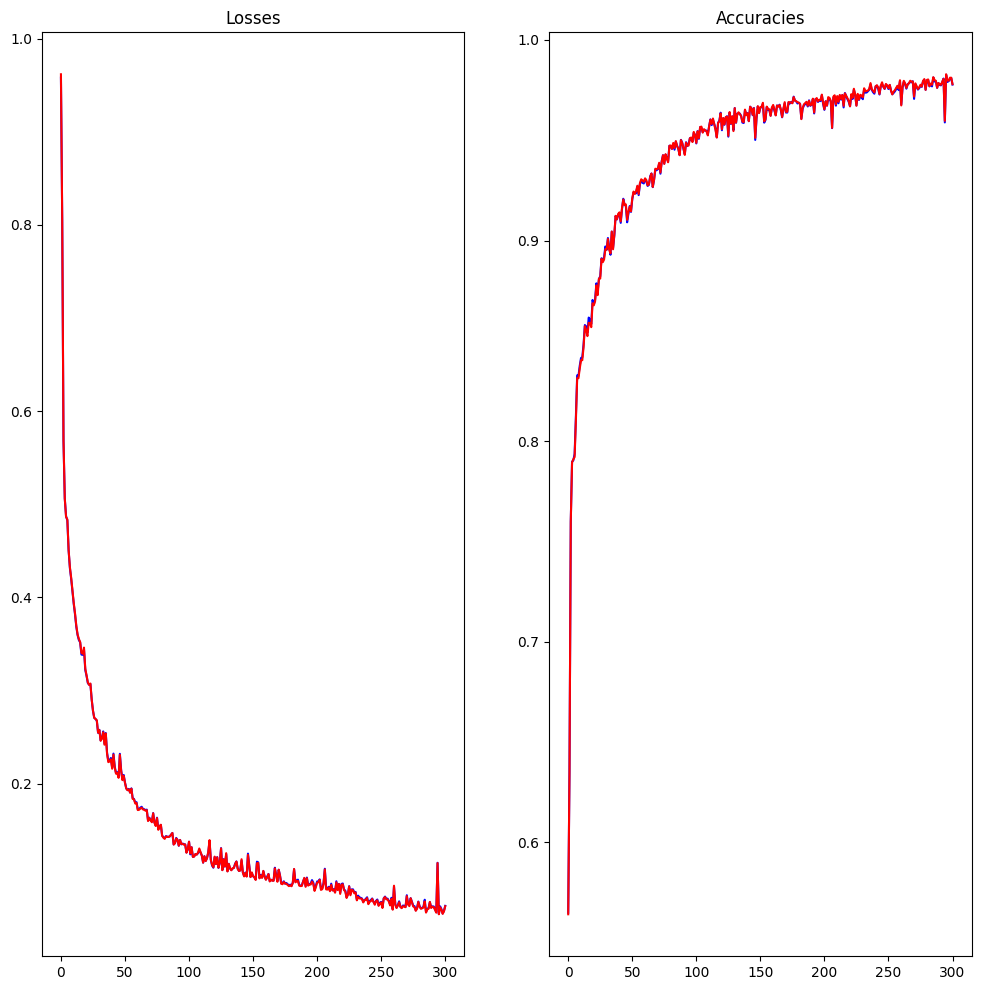

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 12))
axs = axs.flatten()

axs[0].plot(np.arange(0, EPOCHS, 1), trainLosses, color="blue")
axs[0].plot(np.arange(0, EPOCHS, 1), testLosses, color="red")
axs[0].set_title("Losses")

axs[1].plot(np.arange(0, EPOCHS, 1), trainAccuracies, color="blue")
axs[1].plot(np.arange(0, EPOCHS, 1), testAccuracies, color="red")
axs[1].set_title("Accuracies")


In [9]:
MODEL_DST = "./models/"
MODEL_NAME = "imageGradientDensity.pth"

torch.save(model, MODEL_DST + MODEL_NAME)